- ## QAC
- ## AdvantageAC 
- ## EligibilityTraceAC 
- ## PPO
- ## NPG
- ## TRPO
- ## OffPAC 

In [ ]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.distributions as distributions
import scipy.signal as signal
torch.manual_seed(0)

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s',
                    datefmt='%Y/%m/%d %H:%M:%S',
                    stream=sys.stdout,
                    # filemode='w',
                    # filename='log_{}.log'.format{time.strftime('%Y-%m-%d %H-%M-%S',time.localtime(time.time()))},
                    level=logging.DEBUG)

In [ ]:
env = gym.make('Acrobot-v1')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

2021/09/24 09:16:51 [INFO] env: <AcrobotEnv<Acrobot-v1>>
2021/09/24 09:16:51 [INFO] action_space: Discrete(3)
2021/09/24 09:16:51 [INFO] observation_space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
2021/09/24 09:16:51 [INFO] reward_range: (-inf, inf)
2021/09/24 09:16:51 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
2021/09/24 09:16:51 [INFO] _max_episode_steps: 500
2021/09/24 09:16:51 [INFO] _elapsed_steps: None
2021/09/24 09:16:51 [INFO] id: Acrobot-v1
2021/09/24 09:16:51 [INFO] entry_point: gym.envs.classic_control:AcrobotEnv
2021/09/24 09:16:51 [INFO] reward_threshold: -100.0
2021/09/24 09:16:51 [INFO] nondeterministic: False
2021/09/24 09:16:51 [INFO] max_episode_steps: 500
2021/09/24 09:16:51 [INFO] _kwargs: {}
2021/09/24 09:16:51 [INFO] _env_name: Acrobot


In [ ]:
class QActorCriticAgent:
    def __init__(self, env) -> None:
        self.gamma = 0.99
        self.actor_net = self.build_net(
            input_size=env.observation_space.shape[0],
            hidden_sizes=[
                100,
            ],
            output_size=env.action_space.n,
            output_activator=nn.Softmax(1),
        )
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=0.001)

        self.critic_net = self.build_net(
            input_size=env.observation_space.shape[0],
            hidden_sizes=[
                100,
            ],
            output_size=env.action_space.n,
        )
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), lr=0.002)
        self.critic_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size=1, output_activator=None):
        layers = []
        for input_size, output_size in zip(
            [
                input_size,
            ]
            + hidden_sizes,
            hidden_sizes
            + [
                output_size,
            ],
        ):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == "train":
            self.trajectory = []
            self.discount = 1.0

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).reshape(1, -1)
        prob_tensor = self.actor_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == "train":
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) > 8:
                self.learn()
            self.discount *= self.gamma
        return action

    def learn(self):
        state, _, _, action, next_state, reward, done, next_action = self.trajectory[-8:]
        state_tensor = torch.as_tensor(state, dtype=torch.float).unsqueeze(0)
        next_state_tensor = torch.as_tensor(next_state, dtype=torch.float).unsqueeze(0)

        # train actor
        q_tensor = self.critic_net(state_tensor)[0, action]  # -Iq(S,A;w)lnpi(A|S;θ)
        pi_tensor = self.actor_net(state_tensor)[0, action]
        logpi_tensor = torch.log(pi_tensor.clamp(1e-6, 1.0))
        actor_loss_tensor = -self.discount * q_tensor * logpi_tensor
        self.actor_optimizer.zero_grad()
        actor_loss_tensor.backward()
        self.actor_optimizer.step()

        # train critic
        next_q_tensor = self.critic_net(next_state_tensor)[:, next_action]
        target_tensor = reward + (1.0 - done) * self.gamma * next_q_tensor
        pred_tensor = self.critic_net(state_tensor)[:, action]
        critic_loss_tensor = self.critic_loss(pred_tensor, target_tensor)
        self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()

    def close(self):
        pass


agent = QActorCriticAgent(env)


In [ ]:
class AdvantageActorCriticAgent:
    def __init__(self, env):
        self.gamma = 0.99

        self.actor_net = self.build_net(
            input_size=env.observation_space.shape[0],
            hidden_sizes=[
                100,
            ],
            output_size=env.action_space.n,
            output_activator=nn.Softmax(1),
        )
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), 0.0001)
        self.critic_net = self.build_net(
            input_size=env.observation_space.shape[0],
            hidden_sizes=[
                100,
            ],
        )
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.0002)
        self.critic_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size=1, output_activator=None):
        layers = []
        for input_size, output_size in zip(
            [
                input_size,
            ]
            + hidden_sizes,
            hidden_sizes
            + [
                output_size,
            ],
        ):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == "train":
            self.trajectory = []
            self.discount = 1.0

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).reshape(1, -1)
        prob_tensor = self.actor_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == "train":
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                self.learn()
            self.discount *= self.gamma
        return action

    def close(self):
        pass

    def learn(self):
        state, _, _, action, next_state, reward, done, next_action = self.trajectory[-8:]
        state_tensor = torch.as_tensor(state, dtype=torch.float).unsqueeze(0)
        next_state_tensor = torch.as_tensor(next_state, dtype=torch.float).unsqueeze(0)

        # calculate TD error
        next_v_tensor = self.critic_net(next_state_tensor)
        target_tensor = reward + (1.0 - done) * self.gamma * next_v_tensor  # U
        v_tensor = self.critic_net(state_tensor)
        td_error_tensor = target_tensor - v_tensor  # advantage = q - v

        # train actor
        pi_tensor = self.actor_net(state_tensor)[0, action]
        logpi_tensor = torch.log(pi_tensor.clamp(1e-6, 1.0))
        actor_loss_tensor = -(self.discount * td_error_tensor * logpi_tensor).squeeze()
        self.actor_optimizer.zero_grad()
        actor_loss_tensor.backward(retain_graph=True)
        self.actor_optimizer.step()

        # train critic
        pred_tensor = self.critic_net(state_tensor)
        critic_loss_tensor = self.critic_loss(pred_tensor, target_tensor)
        self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()


agent = AdvantageActorCriticAgent(env)


In [ ]:
class PPOReplayer:
    def __init__(self) -> None:
        self.fields = ['state', 'action', 'prob', 'advantage', 'return']
        self.memory = pd.DataFrame(columns=self.fields)

    def store(self, df):
        self.memory = pd.concat([self.memory, df[self.fields]], ignore_index=True)

    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in self.fields)



In [ ]:
class PPOAgent:
    def __init__(self, env):
        self.gamma = 0.99

        self.replayer = PPOReplayer()

        self.actor_net = self.build_net(
            input_size=env.observation_space.shape[0],
            hidden_sizes=[
                100,
            ],
            output_size=env.action_space.n,
            output_activator=nn.Softmax(1),
        )
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), 0.001)
        self.critic_net = self.build_net(
            input_size=env.observation_space.shape[0],
            hidden_sizes=[
                100,
            ],
        )
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.002)
        self.critic_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size=1, output_activator=None):
        layers = []
        for input_size, output_size in zip(
            [
                input_size,
            ]
            + hidden_sizes,
            hidden_sizes
            + [
                output_size,
            ],
        ):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == "train":
            self.trajectory = []

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.actor_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == "train":
            self.trajectory += [observation, reward, done, action]
        return action

    def close(self):
        if self.mode == "train":
            self.save_trajectory_to_replayer()
            if len(self.replayer.memory) >= 1000:
                for batch in range(5):  # learn multiple times
                    self.learn()
                self.replayer = PPOReplayer()  # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(np.array(self.trajectory, dtype=object).reshape(-1, 4), columns=["state", "reward", "done", "action"])
        state_tensor = torch.as_tensor(np.stack(df["state"]), dtype=torch.float)  # xxx * 6
        action_tensor = torch.as_tensor(df["action"], dtype=torch.long)           # xxx
        v_tensor = self.critic_net(state_tensor)                                  # xxx * 1              
        df["v"] = v_tensor.detach().numpy()
        prob_tensor = self.actor_net(state_tensor)                                # xxx * 3 
        pi_tensor = prob_tensor.gather(-1, action_tensor.unsqueeze(1)).squeeze(1) # 选择后为 xxx
        df["prob"] = pi_tensor.detach().numpy()
        df["next_v"] = df["v"].shift(-1).fillna(0.0)
        df["u"] = df["reward"] + self.gamma * df["next_v"]
        df["delta"] = df["u"] - df["v"]     # advantage function
        df["advantage"] = signal.lfilter(
            [
                1.0,
            ],
            [1.0, -self.gamma],
            df["delta"][::-1],
        )[::-1]
        df["return"] = signal.lfilter(
            [
                1.0,
            ],
            [1.0, -self.gamma],
            df["reward"][::-1],
        )[::-1]
        self.replayer.store(df)

    def learn(self):
        states, actions, old_pis, advantages, returns = self.replayer.sample(size=64)
        state_tensor = torch.as_tensor(states, dtype=torch.float)           # 64 * 6
        action_tensor = torch.as_tensor(actions, dtype=torch.long)          # 64
        old_pi_tensor = torch.as_tensor(old_pis, dtype=torch.float)         # 64
        advantage_tensor = torch.as_tensor(advantages, dtype=torch.float)   # 64
        return_tensor = torch.as_tensor(returns, dtype=torch.float).unsqueeze(1)  # 64 * 1

        # train actor
        all_pi_tensor = self.actor_net(state_tensor)                                # 64 * 3            
        pi_tensor = all_pi_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)  # 64
        surrogate_advantage_tensor = (pi_tensor / old_pi_tensor) * advantage_tensor
        clip_times_advantage_tensor = 0.1 * surrogate_advantage_tensor              
        max_surrogate_advantage_tensor = advantage_tensor + torch.where(
            advantage_tensor > 0.0, clip_times_advantage_tensor, -clip_times_advantage_tensor
        )                                                                           # ε|a|  取绝对值              
        clipped_surrogate_advantage_tensor = torch.min(surrogate_advantage_tensor, max_surrogate_advantage_tensor)
        actor_loss_tensor = -clipped_surrogate_advantage_tensor.mean()
        self.actor_optimizer.zero_grad()
        actor_loss_tensor.backward()
        self.actor_optimizer.step()

        # train critic
        pred_tensor = self.critic_net(state_tensor)
        critic_loss_tensor = self.critic_loss(pred_tensor, return_tensor)
        self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()


agent = PPOAgent(env)

In [ ]:
def conjugate_gradient(f, b, iter_count=10, epsilon=1e-12, tol=1e-6):
    x = b * 0.
    r = b.clone()
    p = b.clone()
    rho = torch.dot(r, r)
    for i in range(iter_count):
        z = f(p)
        alpha = rho / (torch.dot(p, z) + epsilon)
        x += alpha * p                # 值更新
        r -= alpha * z                # 残差更新
        rho_new = torch.dot(r, r)
        p = r + (rho_new / rho) * p   # 梯度更新
        rho = rho_new
        if rho < tol:
            break
    return x, f(x)

In [ ]:
class NPGAgent:
    def __init__(self, env):
        self.gamma = 0.99

        self.replayer = PPOReplayer()
        self.trajectory = []

        self.actor_net = self.build_net(
            input_size=env.observation_space.shape[0],
            hidden_sizes=[
                100,
            ],
            output_size=env.action_space.n,
            output_activator=nn.Softmax(1),
        )
        self.max_kl = 0.001
        self.critic_net = self.build_net(
            input_size=env.observation_space.shape[0],
            hidden_sizes=[
                100,
            ],
        )
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.002)
        self.critic_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size=1, output_activator=None):
        layers = []
        for input_size, output_size in zip(
            [
                input_size,
            ]
            + hidden_sizes,
            hidden_sizes
            + [
                output_size,
            ],
        ):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == "train":
            self.trajectory = []

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.actor_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == "train":
            self.trajectory += [observation, reward, done, action]
        return action

    def close(self):
        if self.mode == "train":
            self.save_trajectory_to_replayer()
            if len(self.replayer.memory) >= 1000:
                for batch in range(5):  # learn multiple times
                    self.learn()
                self.replayer = PPOReplayer()  # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(np.array(self.trajectory, dtype=object).reshape(-1, 4), columns=["state", "reward", "done", "action"])
        state_tensor = torch.as_tensor(np.stack(df["state"]), dtype=torch.float)
        action_tensor = torch.as_tensor(df["action"], dtype=torch.long)
        v_tensor = self.critic_net(state_tensor)
        df["v"] = v_tensor.detach().numpy()
        prob_tensor = self.actor_net(state_tensor)
        pi_tensor = prob_tensor.gather(-1, action_tensor.unsqueeze(1)).squeeze(1)
        df["prob"] = pi_tensor.detach().numpy()
        df["next_v"] = df["v"].shift(-1).fillna(0.0)
        df["u"] = df["reward"] + self.gamma * df["next_v"]
        df["delta"] = df["u"] - df["v"]
        df["advantage"] = signal.lfilter(
            [
                1.0,
            ],
            [1.0, -self.gamma],
            df["delta"][::-1],
        )[::-1]
        df["return"] = signal.lfilter(
            [
                1.0,
            ],
            [1.0, -self.gamma],
            df["reward"][::-1],
        )[::-1]
        self.replayer.store(df)

    def learn(self):
        states, actions, old_pis, advantages, returns = self.replayer.sample(size=64)
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        old_pi_tensor = torch.as_tensor(old_pis, dtype=torch.float)
        advantage_tensor = torch.as_tensor(advantages, dtype=torch.float)
        return_tensor = torch.as_tensor(returns, dtype=torch.float).unsqueeze(1)

        # train actor
        # ... calculate first order gradient: g
        all_pi_tensor = self.actor_net(state_tensor)
        pi_tensor = all_pi_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        surrogate_tensor = (pi_tensor / old_pi_tensor) * advantage_tensor   # 代理优势
        loss_tensor = surrogate_tensor.mean()
        loss_grads = autograd.grad(loss_tensor, self.actor_net.parameters())
        loss_grad = torch.cat([grad.view(-1) for grad in loss_grads]).detach()
        # flatten for calculating conjugate gradient

        # ... calculate conjugate gradient: Fx = g
        def f(x):  # calculate Fx 
            prob_tensor = self.actor_net(state_tensor)
            prob_old_tensor = prob_tensor.detach()
            kld_tensor = (prob_old_tensor * (torch.log((prob_old_tensor / prob_tensor).clamp(1e-6, 1e6)))).sum(axis=1)
            kld_loss_tensor = kld_tensor.mean()
            grads = autograd.grad(kld_loss_tensor, self.actor_net.parameters(), create_graph=True)
            flatten_grad_tensor = torch.cat([grad.view(-1) for grad in grads])
            grad_matmul_x = torch.dot(flatten_grad_tensor, x)
            grad_grads = autograd.grad(grad_matmul_x, self.actor_net.parameters())
            flatten_grad_grad = torch.cat([grad.contiguous().view(-1) for grad in grad_grads]).detach()
            fx = flatten_grad_grad + x * 1e-2
            return fx

        x, fx = conjugate_gradient(f, loss_grad)

        # ... calculate natural gradient: sqrt(...) g
        natural_gradient = torch.sqrt(2 * self.max_kl / torch.dot(fx, x)) * x   # (√（2 * δ）/ (x * F * x) )x

        # ... update actor net
        begin = 0
        for param in self.actor_net.parameters():
            end = begin + param.numel()
            param.data.copy_(natural_gradient[begin:end].view(param.size()) + param.data)
            begin = end

        # train critic
        pred_tensor = self.critic_net(state_tensor)
        critic_loss_tensor = self.critic_loss(pred_tensor, return_tensor)
        self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()


agent = NPGAgent(env)


In [ ]:
class TRPOAgent:
    def __init__(self, env):
        self.gamma = 0.99

        self.replayer = PPOReplayer()
        self.trajectory = []

        self.actor_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,],
                output_size=env.action_space.n, output_activator=nn.Softmax(1))
        self.max_kl = 0.01
        self.critic_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,])
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.002)
        self.critic_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.actor_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.save_trajectory_to_replayer()
            if len(self.replayer.memory) >= 1000:
                for batch in range(5): # learn multiple times
                    self.learn()
                self.replayer = PPOReplayer() # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(
                np.array(self.trajectory, dtype=object).reshape(-1, 4),
                columns=['state', 'reward', 'done', 'action'])
        state_tensor = torch.as_tensor(np.stack(df['state']), dtype=torch.float)
        action_tensor = torch.as_tensor(df['action'], dtype=torch.long)
        v_tensor = self.critic_net(state_tensor)
        df['v'] = v_tensor.detach().numpy()
        prob_tensor = self.actor_net(state_tensor)
        pi_tensor = prob_tensor.gather(-1, action_tensor.unsqueeze(1)).squeeze(1)
        df['prob'] = pi_tensor.detach().numpy()
        df['next_v'] = df['v'].shift(-1).fillna(0.)
        df['u'] = df['reward'] + self.gamma * df['next_v']
        df['delta'] = df['u'] - df['v']
        df['advantage'] = signal.lfilter([1.,], [1., -self.gamma],
                df['delta'][::-1])[::-1]
        df['return'] = signal.lfilter([1.,], [1., -self.gamma],
                df['reward'][::-1])[::-1]
        self.replayer.store(df)

    def learn(self):
        states, actions, old_pis, advantages, returns = \
                self.replayer.sample(size=64)
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        old_pi_tensor = torch.as_tensor(old_pis, dtype=torch.float)
        advantage_tensor = torch.as_tensor(advantages, dtype=torch.float)
        return_tensor = torch.as_tensor(returns, dtype=torch.float).unsqueeze(1)

        # train actor
        # ... calculate first order gradient: g
        all_pi_tensor = self.actor_net(state_tensor)
        pi_tensor = all_pi_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        surrogate_tensor = (pi_tensor / old_pi_tensor) * advantage_tensor
        loss_tensor = surrogate_tensor.mean()
        loss_grads = autograd.grad(loss_tensor, self.actor_net.parameters())
        loss_grad = torch.cat([grad.view(-1) for grad in loss_grads]).detach()
                # flatten for calculating conjugate gradient

        # ... calculate conjugate gradient: Fx = g
        def f(x): # calculate Fx
            prob_tensor = self.actor_net(state_tensor)
            prob_old_tensor = prob_tensor.detach()
            kld_tensor = (prob_old_tensor * torch.log(
                    (prob_old_tensor / prob_tensor).clamp(1e-6, 1e6))).sum(axis=1)
            kld_loss_tensor = kld_tensor.mean()
            grads = autograd.grad(kld_loss_tensor, self.actor_net.parameters(), create_graph=True)
            flatten_grad_tensor = torch.cat([grad.view(-1) for grad in grads])
            grad_matmul_x = torch.dot(flatten_grad_tensor, x)
            grad_grads = autograd.grad(grad_matmul_x, self.actor_net.parameters())
            flatten_grad_grad = torch.cat([grad.contiguous().view(-1) for grad in grad_grads]).detach()
            fx = flatten_grad_grad + x * 0.01
            return fx
            
        x, fx = conjugate_gradient(f, loss_grad)

        # ... calculate natural gradient: sqrt(...) g
        natural_gradient_tensor = torch.sqrt(2 * self.max_kl / torch.dot(fx, x)) * x

        # ... line search
        def set_actor_net_params(flatten_params):
                # auxiliary function to overwrite actor_net
            begin = 0
            for param in self.actor_net.parameters():
                end = begin + param.numel()
                param.data.copy_(flatten_params[begin:end].view(param.size()))
                begin = end

        old_param = torch.cat([param.view(-1) for param in self.actor_net.parameters()])
        expected_improve = torch.dot(loss_grad, natural_gradient_tensor)
        for learning_step in [0.,] + [.5 ** j for j in range(10)]:
            new_param = old_param + learning_step * natural_gradient_tensor
            set_actor_net_params(new_param)
            all_pi_tensor = self.actor_net(state_tensor)
            new_pi_tensor = all_pi_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
            new_pi_tensor = new_pi_tensor.detach()
            surrogate_tensor = (new_pi_tensor / pi_tensor) * advantage_tensor
            objective = surrogate_tensor.mean().item()
            if np.isclose(learning_step, 0.):
                old_objective = objective
            else:
                if objective - old_objective > 0.1 * expected_improve * learning_step:
                    break # success, keep the weight
                else:
                    set_actor_net_params(old_param)

        # train critic
        pred_tensor = self.critic_net(state_tensor)
        critic_loss_tensor = self.critic_loss(pred_tensor, return_tensor)
        self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()


agent = TRPOAgent(env)

2021/09/24 09:17:31 [INFO] ==== train ====
2021/09/24 09:17:31 [DEBUG] train episode 0: reward = -500.00, steps = 500
2021/09/24 09:17:31 [DEBUG] train episode 1: reward = -356.00, steps = 357
2021/09/24 09:17:31 [DEBUG] train episode 2: reward = -296.00, steps = 297
2021/09/24 09:17:31 [DEBUG] train episode 3: reward = -417.00, steps = 418
2021/09/24 09:17:31 [DEBUG] train episode 4: reward = -500.00, steps = 500
2021/09/24 09:17:32 [DEBUG] train episode 5: reward = -364.00, steps = 365
2021/09/24 09:17:32 [DEBUG] train episode 6: reward = -464.00, steps = 465
2021/09/24 09:17:32 [DEBUG] train episode 7: reward = -323.00, steps = 324
2021/09/24 09:17:32 [DEBUG] train episode 8: reward = -318.00, steps = 319
2021/09/24 09:17:32 [DEBUG] train episode 9: reward = -337.00, steps = 338
2021/09/24 09:17:32 [DEBUG] train episode 10: reward = -410.00, steps = 411
2021/09/24 09:17:33 [DEBUG] train episode 11: reward = -500.00, steps = 500
2021/09/24 09:17:33 [DEBUG] train episode 12: reward = 

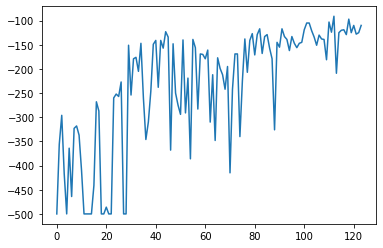

In [ ]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0.0, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0.0, 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info("==== train ====")
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent, max_episode_steps=env._max_episode_steps, mode="train")
    episode_rewards.append(episode_reward)
    logging.debug("train episode %d: reward = %.2f, steps = %d", episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info("==== test ====")
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug("test episode %d: reward = %.2f, steps = %d", episode, episode_reward, elapsed_steps)
logging.info("average episode reward = %.2f ± %.2f", np.mean(episode_rewards), np.std(episode_rewards))


In [12]:
env.close()

NameError: name 'env' is not defined

In [14]:
import torch

a = torch.randn((4,4))
print(a)

print(a.view(-1))
print(a.view(-1).shape)


tensor([[-0.4473, -1.1535, -0.4113,  0.2611],
        [ 0.3292,  1.2799, -0.6077,  0.8817],
        [ 1.4185, -0.5777, -0.4612, -1.3332],
        [-2.2493, -0.1598,  2.1922, -0.5020]])


TypeError: view() received an invalid combination of arguments - got (int, dim=int), but expected one of:
 * (tuple of ints size)
 * (torch.dtype dtype)
